In [6]:
# !git clone https://github.com/princeton-vl/RAFT.git


Cloning into 'RAFT'...


In [1]:
import os
import sys
import numpy as np
import cv2
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Добавляем путь к RAFT
sys.path.append('/home/jupyter/datasphere/project/RAFT/core')

In [2]:
# %cd RAFT
# !./download_models.sh
# # !python demo.py --model=models/raft-things.pth --path=demo-frames
# %cd ..

/home/jupyter/work/resources/RAFT
Archive:  models.zip
   creating: models/
  inflating: models/raft-kitti.pth   
  inflating: models/raft-sintel.pth  
  inflating: models/raft-chairs.pth  
  inflating: models/raft-things.pth  
  inflating: models/raft-small.pth   
/home/jupyter/work/resources


--2024-11-23 15:12:23--  https://dl.dropboxusercontent.com/s/4j4z58wuv8o0mfz/models.zip
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.71.15, 2620:100:6022:15::a27d:420f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.71.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81977417 (78M) [application/zip]
Saving to: ‘models.zip’

     0K .......... .......... .......... .......... ..........  0%  161K 8m17s
    50K .......... .......... .......... .......... ..........  0%  530K 5m24s
   100K .......... .......... .......... .......... ..........  0%  974K 4m3s
   150K .......... .......... .......... .......... ..........  0%  979K 3m23s
   200K .......... .......... .......... .......... ..........  0% 1.48M 2m52s
   250K .......... .......... .......... .......... ..........  0% 1.40M 2m33s
   300K .......... .......... .......... .......... ..........  0% 1.99M 2m17s
   350K .......... .......... ......

In [3]:
from collections import OrderedDict
from raft import RAFT
from utils import flow_viz
from utils.utils import InputPadder



def process_img(img, device):
    return torch.from_numpy(img).permute(2, 0, 1).float()[None].to(device)


def load_model(weights_path, args):
    model = RAFT(args)
    pretrained_weights = torch.load(weights_path, map_location=torch.device("cpu"))
    model = torch.nn.DataParallel(model)
    model.load_state_dict(pretrained_weights)
    model.to("cuda")
    return model


def inference(model, frame1, frame2, device, pad_mode='sintel',
              iters=12, flow_init=None, upsample=True, test_mode=True):

    model.eval()
    with torch.no_grad():
        # preprocess
        frame1 = process_img(frame1, device)
        frame2 = process_img(frame2, device)

        padder = InputPadder(frame1.shape, mode=pad_mode)
        frame1, frame2 = padder.pad(frame1, frame2)

        # predict flow
        if test_mode:
          flow_low, flow_up = model(frame1,
                                    frame2,
                                    iters=iters,
                                    flow_init=flow_init,
                                    upsample=upsample,
                                    test_mode=test_mode)



          return flow_low, flow_up

        else:
            flow_iters = model(frame1,
                               frame2,
                               iters=iters,
                               flow_init=flow_init,
                               upsample=upsample,
                               test_mode=test_mode)

            return flow_iters


def get_viz(flo):
    flo = flo[0].permute(1,2,0).cpu().numpy()
    return flow_viz.flow_to_image(flo)

# sketchy class to pass to RAFT
class Args():
  def __init__(self, model='', path='', small=False, mixed_precision=True, alternate_corr=False):
    self.model = model
    self.path = path
    self.small = small
    self.mixed_precision = mixed_precision
    self.alternate_corr = alternate_corr

  """ Sketchy hack to pretend to iterate through the class objects """
  def __iter__(self):
    return self

  def __next__(self):
    raise StopIteration

In [4]:
import torch
from raft import RAFT  # Путь к файлу, где определена модель RAFT

# Путь к предобученной модели
pretrained_model_path = '/home/jupyter/datasphere/project/RAFT/models/raft-sintel.pth'

# Инициализация модели RAFT
model = load_model(pretrained_model_path, args=Args())

# Загрузка предобученных весов
checkpoint = torch.load(pretrained_model_path)
model.load_state_dict(checkpoint)

# Перевод модели на GPU (если доступно)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Убедимся, что модель успешно загружена
print("Модель RAFT успешно загружена и готова к дообучению.")

Модель RAFT успешно загружена и готова к дообучению.


In [5]:
demo_path = 'RAFT/demo-frames'
frame1 = cv2.imread(os.path.join(demo_path, 'frame_0020.png'))
frame2 = cv2.imread(os.path.join(demo_path, 'frame_0021.png'))

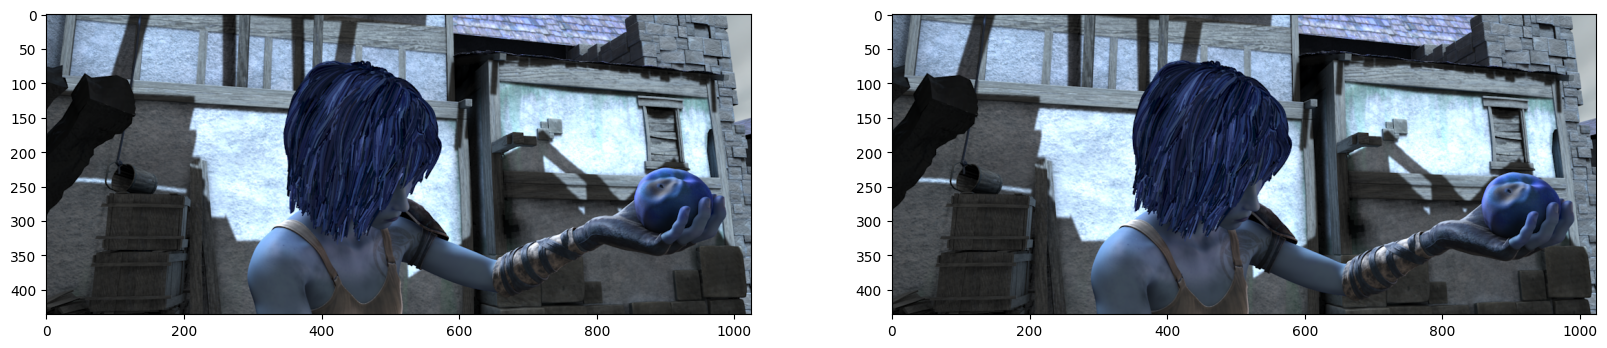

In [6]:
_, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].imshow(frame1)
ax[1].imshow(frame2);

In [7]:
flow_low, flow_up = inference(model, frame1, frame2, device='cuda')

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
flow_low.shape, flow_up.shape


(torch.Size([1, 2, 55, 128]), torch.Size([1, 2, 440, 1024]))

In [9]:
flow_low_viz = get_viz(flow_low)
flow_up_viz = get_viz(flow_up)

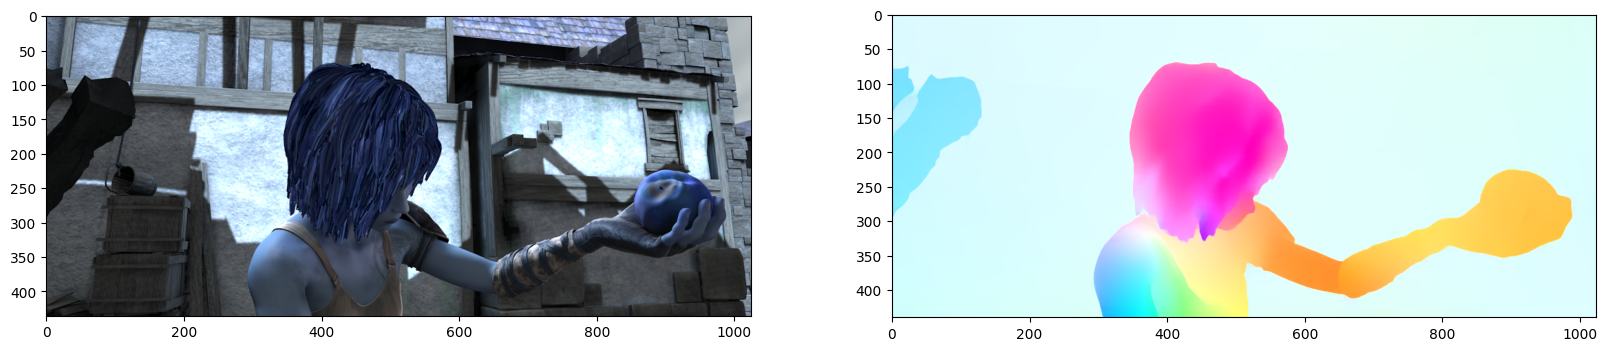

In [10]:
f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(frame1)
ax1.imshow(flow_up_viz)
plt.show()

In [26]:
# from PIL import Image
# import numpy as np
# import torch
# from torch.utils.data import Dataset

# class OpticalFlowDataset(Dataset):
#     def __init__(self, matched_files, transform=None):
#         """
#         Инициализация кастомного датасета для загрузки оптического потока.
        
#         Parameters:
#         - matched_files: list of dict, список с путями к изображениям, потокам и маскам.
#         - transform: callable, трансформация для изображений.
#         """
#         self.matched_files = matched_files
#         self.transform = transform

#     def __len__(self):
#         """Возвращает количество примеров в датасете."""
#         return len(self.matched_files)

#     def __getitem__(self, idx):
#         """Загружает изображения, поток и маску по индексу."""
#         match = self.matched_files[idx]
#         img1_path = match['img1']
#         img2_path = match['img2']
#         flow_path = match['flow']
#         mask_path = match['mask']
        
#         # Загружаем изображения
#         img1 = Image.open(img1_path).convert("RGB")  # Первое изображение
#         img2 = Image.open(img2_path).convert("RGB")  # Второе изображение
        
#         # Загружаем поток и маску
#         flow = np.load(flow_path)  # Поток (H, W, 2)
#         mask = np.load(mask_path)  # Маска (H, W)

#         # Применяем трансформации (если они есть)
#         if self.transform:
#             img1 = self.transform(img1)
#             img2 = self.transform(img2)

#         # Преобразуем поток и маску в тензоры
#         flow = torch.tensor(flow.transpose(2, 0, 1), dtype=torch.float32)  # (2, H, W) для RAFT
#         mask = torch.tensor(mask, dtype=torch.float32)  # Маска (H, W)

#         return img1, img2, flow, mask


In [11]:
# Загрузка предобученных весов
checkpoint = torch.load(pretrained_model_path)
model.load_state_dict(checkpoint)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [22]:
sys.path.append('/home/jupyter/datasphere/project/RAFT')

In [29]:
!cd /home/jupyter/datasphere/project/RAFT
# не меняет

In [12]:
import os
os.chdir('/home/jupyter/datasphere/project/RAFT')  # Поменяйте на правильный путь
print("Новый рабочий каталог:", os.getcwd())

Новый рабочий каталог: /home/jupyter/work/resources/RAFT


In [ ]:
!python3 train.py --stage venus --restore_ckpt /home/jupyter/datasphere/project/RAFT/models/raft-sintel.pth --gpus 0

In [39]:
!sed -i 's/from frame_utils import read_gen, readFlow, readFlowKITTI/from units.frame_utils import read_gen, readFlow, readFlowKITTI/g' /home/jupyter/work/resources/RAFT/core/datasets.py

In [12]:
!sed -i 's/from frame_utils import read_gen, readFlow, readFlowKITTI/from utils.frame_utils import read_gen, readFlow, readFlowKITTI/g' /home/jupyter/work/resources/RAFT/core/datasets.py

In [16]:
!sed -i 's/from units.frame_utils import read_gen, readFlow, readFlowKITTI/from units.frame_utils import read_gen, readFlow, readFlowKITTI/g' /home/jupyter/work/resources/RAFT/core/datasets.py

In [45]:
!./train_standard.sh

./train_standard.sh: line 3: python: command not found
./train_standard.sh: line 4: python: command not found
./train_standard.sh: line 5: python: command not found
./train_standard.sh: line 6: python: command not found


Exception: Process exited with code 127